In [7]:
%load_ext autoreload
%autoreload 2
from coronita_odeint_model import *
from coronita_model_helper_new import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
## DATA INGESTION ##

df_st_testing = get_covid19_tracking_data()

df_census = get_census_pop()

# counties_geo = get_counties_geo()

# df_jhu_counties = get_jhu_counties()

df_st_testing_fmt = df_st_testing.copy()
df_st_testing_fmt = df_st_testing_fmt.rename(columns={'death':'deaths','positive':'cases'}).unstack('code')

try:
    df_interventions = get_state_policy_events()
except:
    df_interventions = pd.DataFrame()

df_goog_mob_us = get_goog_mvmt_us()
df_goog_mob_state = get_goog_mvmt_state(df_goog_mob_us)

df_counties = get_complete_county_data(df_census, df_goog_mob_us)

df_hhs_hosp = get_hhs_hosp()

df_can = get_can_data()

df_vax_hes = get_vax_hesitancy_data()


State Testing Data Last Observation:  20210307
Got COVID19 Tracking Data
Got CDC Death Data
Got HHS testing data
Got HHS hospital data.
Got Census Data
Got KFF Policy dates
Got Google Movement Data
Got NYS DOH data
Got NYT county level data.
Got NYC DOH data
Got Complete County Time Series Data
Got HHS hospitalization data.
Got COVID Act Now data.
Got Census Data
Got HHS Vaccine Hesitancy Data.


In [3]:
# list_of_files = glob.glob('./output/allstate_model_dicts_*.pkl') # * means all if need specific format then *.csv
# latest_file = max(list_of_files, key=os.path.getctime)
# print(latest_file)
# with open(latest_file, 'rb') as handle:
#     allstate_model_dicts = pickle.load(handle)
    

## Main Non-Cohort Version with Minimization

In [8]:
## MODEL PARAMETERS ##

covid_params = {}
covid_params['d_incub'] = 3.
covid_params['d_infect'] = 4.
covid_params['mort_rt'] = 0.01
covid_params['d_in_hosp'] = 11
covid_params['hosp_rt'] = 0.04
covid_params['d_to_hosp'] = 7.0
covid_params['d_in_hosp_mild'] = 11.0
covid_params['icu_rt'] = 13./41.
covid_params['d_in_icu'] = 13.0
covid_params['vent_rt'] = 0.4
covid_params['d_til_death'] =  17.0
covid_params['policy_trigger'] = True
covid_params['policy_trigger_once'] = True
days_to_forecast = 150

covid_params['eff_vax_half'] = 0.8
covid_params['eff_vax_full'] = 0.9

In [40]:
state = 'NY'
model_dict = make_model_dict_state(state, abbrev_us_state, df_census, df_st_testing_fmt, df_hhs_hosp, 
                                   df_can, df_counties, df_vax_hes,
                                       covid_params, days_to_forecast,
                                       df_mvmt=df_goog_mob_state
                                     , df_interventions=df_interventions
                                      )

deaths shifted by:  -20


In [18]:
# state_code = 'NY'
# model_dict = allstate_model_dicts[state_code].copy()

state = 'CA'
model_dict = make_model_dict_state(state, abbrev_us_state, df_census, df_st_testing_fmt, df_hhs_hosp, 
                                   df_can, df_counties, df_vax_hes,
                                       covid_params, days_to_forecast,
                                       df_mvmt=df_goog_mob_state
                                     , df_interventions=df_interventions
                                      )
print(f'model_dict[state_code]: {model_dict["region_code"]}')

time_dict = {}
time_dict['days'] = 100
time_dict['hrs_per_point'] = 24
time_dict['granularity'] = time_dict['hrs_per_point']/24.
time_dict['tspan'] = np.arange(0, time_dict['days'], time_dict['granularity'])

initN = model_dict['tot_pop']

from lmfit import minimize, Parameters, Parameter, report_fit

params = Parameters()
params.add('d_incub', value=model_dict['covid_params']['d_incub'], min=2, max=5)
params.add('d_infect', value=model_dict['covid_params']['d_infect'], min=2, max=7)
params.add('d_to_hosp', value=model_dict['covid_params']['d_to_hosp'], min=2, max=10)
params.add('d_in_hosp', value=model_dict['covid_params']['d_in_hosp'], min=2, max=20)
params.add('d_til_death', value=model_dict['covid_params']['d_til_death'], min=5, max=30)
# params.add('d_til_death_curr', value=model_dict['covid_params']['d_til_death'], min=8, max=45)
params.add('mort_rt', value=model_dict['covid_params']['mort_rt'], min=0.001, max=0.04)
# params.add('mort_logistic_steepness', value=0.25, min=0.05, max=1)
# params.add('mort_rt_curr', value=0.0075, min=0.001, max=0.02)
params.add('hosp_rt', value=model_dict['covid_params']['hosp_rt'], min=0.01, max=0.15)
params.add('start_dt', value=15, min=0, max=100)

initE, E_new = 1e1, 1e1
initI_Mild, initI_Sev, initI_Fatal = 0, 0, 0
initH_Sev, initH_Fatal, initH_Admits = 0, 0, 0
initR = 0
initD = 0
initial_conditions = [initN, initE, E_new,
                      initI_Mild, initI_Sev, initI_Fatal, 
                      initH_Sev, initH_Fatal, initH_Admits, 
                      initR, initD]



data = model_dict['df_hist'][['hosp_concur', 'hosp_admits', 'deaths_daily']].dropna(how='any')

r_ts = model_dict['df_rts']['weighted_average'].dropna()
r_ts = r_ts.loc[r_ts.loc[:'2020-04-15'].idxmax():]
r_ts = r_ts.reindex(pd.date_range('2020-01-01', periods=365*2, freq='1D'))
r_ts = r_ts.interpolate().fillna(method='ffill').fillna(method='bfill')

sol = run_model(params, initial_conditions, time_dict, r_ts)
df_sol = sol_array_to_df(sol, params, time_dict)
# report_model(r_ts, df_sol, model_dict, params, time_dict)

### STEP 1: Find Best Starting Date ###

# First Brute Force
for key in params.keys():
    params[key].set(vary=False)
params['start_dt'].set(vary=True)

result = minimize(error, 
                  params, 
                  args=(initial_conditions, time_dict, r_ts, data)
                  , method='brute'
                  , nan_policy= 'omit'
                 )
print('==================Found Best Starting Date==================')
display(result)
params['start_dt'].set(value=result.params['start_dt'].value, vary=False)

sol = run_model(params, initial_conditions, time_dict, r_ts)
df_sol = sol_array_to_df(sol, params, time_dict)
report_model(r_ts, df_sol, model_dict, params, time_dict)


deaths shifted by:  -20
model_dict[state_code]: CA


ValueError: attempt to get argmin of an empty sequence

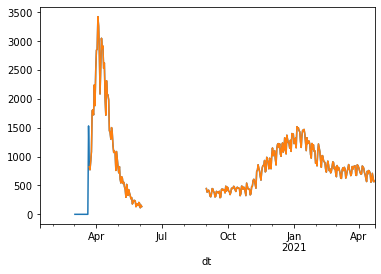

In [48]:
model_dict['df_hist']['hosp_admits'].plot()
leading_zeros2nan(model_dict['df_hist']['hosp_admits']).plot()

In [47]:
def leading_zeros2nan(input_series):
    first_nonzero_idx = input_series[input_series > 0].first_valid_index()
    input_series.loc[:first_nonzero_idx] = np.nan
    return input_series

In [46]:
model_dict['df_hist']['hosp_admits'][model_dict['df_hist']['hosp_admits'] > 0].first_valid_index()

Timestamp('2020-03-21 00:00:00')

In [39]:
leading_zeros2nan(data['hosp_admits'])

dt
2020-03-27      NaN
2020-03-28      NaN
2020-03-29      NaN
2020-03-30      NaN
2020-03-31      NaN
              ...  
2021-04-19      NaN
2021-04-20      NaN
2021-04-21      NaN
2021-04-22      NaN
2021-04-23    714.0
Name: hosp_admits, Length: 393, dtype: float64

In [23]:
window_start = '2020-01-01'
window_end = '2020-07-01'
df_sol['E', 'E_new', 'I_Mild', 'I_Sev', 'I_Fatal', 'H_Sev', 'H_Fatal', 'H_Admits', 'R', 'D']


,E,E_new,I_Mild,I_Sev,I_Fatal,H_Sev,H_Fatal,H_Admits,R,D,deaths_tot,deaths_daily,hosp_admits,hosp_concur
2020-01-27,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,NaN,0.000000,0.000000
2020-01-28,8.304067,4.605017,2.518988,0.074784,0.029389,0.005474,0.002194,0.005734,3.391664e-01,0.000025,0.000025,0.000025,0.005734,0.007668
2020-01-29,8.759896,3.841412,4.349052,0.135549,0.053269,0.019473,0.007958,0.016008,1.205096e+00,0.000185,0.000185,0.000160,0.016008,0.027431
2020-01-30,10.499438,4.608958,6.104843,0.197926,0.077782,0.040536,0.016882,0.027434,2.511974e+00,0.000591,0.000591,0.000405,0.027434,0.057418
2020-01-31,13.253997,6.021003,8.118062,0.271065,0.106525,0.068947,0.029221,0.040194,4.286817e+00,0.001349,0.001349,0.000758,0.040194,0.098168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-01,17243.933786,5074.037030,28805.423601,1739.106427,683.443469,4365.790131,4585.540194,365.501111,1.007217e+06,5940.996812,5940.996812,153.752352,365.501111,8951.330325
2020-05-02,16427.281000,4883.699305,27206.913527,1649.128514,648.083462,4217.592659,4528.710683,346.580338,1.014606e+06,6092.909756,6092.909756,151.912944,346.580338,8746.303341
2020-05-03,15720.436404,4723.798988,25746.920404,1564.745879,614.922316,4070.372074,4468.930560,328.709078,1.021599e+06,6242.878064,6242.878064,149.968308,328.709078,8539.302633
2020-05-04,15112.640509,4590.246414,24424.286393,1486.088294,584.011032,3924.817861,4406.609630,311.938428,1.028231e+06,6390.810226,6390.810226,147.932162,311.938428,8331.427491
